In [ ]:
# !pip install seqeval==0.0.5
# !pip install keras==2.2.4
# !pip install tensorflow==1.14.0
# !git clone https://www.github.com/keras-team/keras-contrib.git
# %cd keras-contrib
# !python setup.py install
# !pip install pyvi

In [ ]:
%%capture
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import *
import torch
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from bs4 import BeautifulSoup
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input, load_model
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras_contrib.layers import CRF
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
graph = tf.get_default_graph()

In [ ]:
#declare the directory path to dataset  
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/zalo/data/'
MODEL_LSTM_PATH="/content/drive/My Drive/Colab Notebooks/zalo/model_ner/lstm_crf"
# SAMPLE_DATA_PATH = f'{DATA_PATH}sample_data/'
# PROCESSED_DATA_PATH = f'{DATA_PATH}processed_data/'
TRAIN_DATA_PATH = f'{DATA_PATH}train_preprocess.csv'
# VOCAB_DATA_PATH = f'{DATA_PATH}create_vocab.csv'
#Enable GPU training 
import torch
USE_GPU = torch.cuda.is_available()
print('USE_GPU={}'.format(USE_GPU))
if USE_GPU:
    print('current_device={}'.format(torch.cuda.current_device()))

USE_GPU=True
current_device=0


In [ ]:

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/zalo/')
import utils
# import get_event

In [ ]:
# Hyperparams if GPU is available
if USE_GPU:
    BATCH_SIZE = 8  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 100  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 8
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 100

In [ ]:
data = pd.read_csv(TRAIN_DATA_PATH)
data = data.fillna(method="ffill")
# print("Number of sentences: ", len(data.groupby(['Sentence #'])))
words = list(set(data["Word"].values))
n_words = len(words)
# print("Number of words in the dataset: ", n_words)
tags = list(set(data["Tag"].values))
# print("Tags:", tags)
n_tags = len(tags)
# print("Number of Labels: ", n_tags)
# print("What the dataset looks like:")
# Show the first 10 rows
# data.head(n=10)

# Preprocessing

In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
# print('cầu thủ vào sân thay người là Ronaldo')
# print(sent)

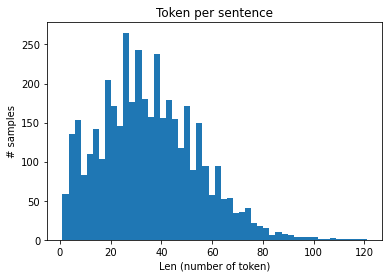

In [ ]:
# Get all the sentences
sentences = getter.sentences
# Plot sentence by lenght
# plt.hist([len(s) for s in sentences], bins=50)
# plt.title('Token per sentence')
# plt.xlabel('Len (number of token)')
# plt.ylabel('# samples')
# plt.show()

# FURTHER DATA PREPROCESSING

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
words = list(data['Word'].unique())
tags = list(data['Tag'].unique())
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}
# print("The word Ronaldo is identified by the index: {}".format(word2idx["ronaldo"]))
# print("The labels score2 is identified by the index: {}".format(tag2idx["score2"]))
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
num_tag = data['Tag'].nunique()
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape
# print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
# print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
# print('After processing, sample:', X[0])
# print('After processing, labels:', y[0])

# Implementing Model Architecture

In [ ]:

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=len(words)+2, output_dim=EMBEDDING,input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.4))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
# model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib-2.0.8-py3.6.egg/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/usr/local/lib/python3.6/dist-packages/keras_contrib-2.0.8-py3.6.egg/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           510700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            10050     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 15)            1020      
Total params: 682,570
Trainable params: 682,570
Non-trainable params: 0
_________________________________________________________________


# Training and Evaluation of the Model

In [ ]:
# history = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1,verbose=2)

Train on 3362 samples, validate on 374 samples
Epoch 1/5
 - 66s - loss: 8.0480 - crf_viterbi_accuracy: 0.8818 - val_loss: 7.8855 - val_crf_viterbi_accuracy: 0.9008
Epoch 2/5
 - 61s - loss: 7.7473 - crf_viterbi_accuracy: 0.9157 - val_loss: 7.7254 - val_crf_viterbi_accuracy: 0.9264
Epoch 3/5
 - 60s - loss: 7.6494 - crf_viterbi_accuracy: 0.9302 - val_loss: 7.7009 - val_crf_viterbi_accuracy: 0.9308
Epoch 4/5
 - 56s - loss: 7.6133 - crf_viterbi_accuracy: 0.9370 - val_loss: 7.6697 - val_crf_viterbi_accuracy: 0.9361
Epoch 5/5
 - 56s - loss: 7.5906 - crf_viterbi_accuracy: 0.9426 - val_loss: 7.6592 - val_crf_viterbi_accuracy: 0.9391


In [ ]:
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=-1)
# y_test_true = np.argmax(y_test, -1)
 
# # Kiểm thử F1-Score
# y_pred = [[idx2tag[i] for i in row] for row in y_pred]
# y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]
# # print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

In [ ]:
# from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
# idx2tag = {i: w for w, i in tag2idx.items()}
# def pred2label(pred):
#     out = []
#     for pred_i in pred:
#         out_i = []
#         for p in pred_i:
#             p_i = np.argmax(p)
#             out_i.append(idx2tag[p_i].replace("PAD", "O"))
#         out.append(out_i)
#     return out
# test_pred = model.predict(X_test, verbose=2)    
# pred_labels = pred2label(test_pred)
# test_labels = pred2label(y_test)
# print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 64.4%


In [ ]:
# print(classification_report(test_labels, pred_labels))

                              precision    recall  f1-score   support

 substitution_list_player_in       0.58      0.54      0.56        13
               players_team1       0.34      0.44      0.39        61
substitution_list_player_out       0.47      0.54      0.50        13
             score_list_team       0.64      0.76      0.70       188
             score_list_time       0.79      0.67      0.72       261
          score_board_score1       0.63      0.60      0.62        80
          score_board_score2       0.57      0.59      0.58        71
      score_list_player_name       0.73      0.71      0.72       308
               players_team2       0.43      0.14      0.21        63
       card_list_player_name       0.75      0.33      0.46         9
              card_list_team       0.00      0.00      0.00         4
              card_list_time       1.00      0.20      0.33         5
      substitution_list_time       0.22      0.29      0.25         7

                 a

In [ ]:
# model.save(MODEL_LSTM_PATH)

In [ ]:
model_lstm= load_model(MODEL_LSTM_PATH,custom_objects={'CRF':CRF, 'crf_loss':crf_loss,'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [ ]:
# # Test với một câu ngẫu nhiên trong tập test
# idx = np.random.randint(0,X_test.shape[0])
# p_t = model_lstm.predict(np.array([X_test[idx]]))
# p_t = np.argmax(p_t, axis=-1)
# true = np.argmax(y_test[idx], -1)

# print("Example #{}".format(idx))

# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(40 * "*")
# for w, t, pred in zip(X_test[idx], true, p_t[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Example #407
Word           ||True ||Pred
****************************************
Trận           : O     O
đấu            : O     O
đã             : O     O
kết            : O     O
thúc           : O     O
với            : O     O
tỷ             : O     O
số             : O     O
4              : O     score_board_score1
3              : O     score_board_score2
chung          : O     O
cuộc           : O     O
nghiêng        : O     O
về             : O     O
U23            : score_list_team O
Arsenal        : O     O
Về             : O     O
phía           : O     O
U23            : O     score_list_team
Man            : score_list_team score_list_team
City           : score_list_team score_list_team
ba             : O     O
bàn            : O     O
thắng          : O     O
của            : O     O
họ             : O     O
được           : O     O
ghi            : O     O
do             : O     O
công           : O     O
của            : O     O
Matt           : score_list_player_n

In [ ]:
# clean_sent = (sentence).split() 
# embedding_sent = pad_sequences(sequences=[[word2idx[w] for w in clean_sent]],padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)

In [ ]:
# embedding_sent=pad_sequences(maxlen=MAX_LEN, sequences=[[word2idx.get(w, 0) for w in clean_sent]], padding="post", value=word2idx["PAD"])

In [ ]:
# p = model.predict(np.array([embedding_sent[0]]))
# p = np.argmax(p, axis=-1)
# print("{:15}||{}".format("Word", "Prediction"))
# print(30 * "=")
# for w, pred in zip(clean_sent, p[0]):
#     print("{:15}: {:5}".format(w, idx2tag[pred]))